In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Get project paths correctly
current_dir = Path.cwd()
project_root = current_dir.parent  # diffCherenkov root (one level up from notebooks)
photonsim_root = project_root.parent / 'PhotonSim'  # PhotonSim root

# Add project paths
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'tools'))

print(f"Current dir: {current_dir}")
print(f"Project root: {project_root}")
print(f"PhotonSim root: {photonsim_root}")

# Verify paths exist
print(f"Project root exists: {project_root.exists()}")
print(f"Siren dir exists: {(project_root / 'siren').exists()}")
print(f"Training dir exists: {(project_root / 'siren' / 'training').exists()}")
print(f"PhotonSim root exists: {photonsim_root.exists()}")

Current dir: /sdf/home/c/cjesus/Dev/diffCherenkov/notebooks
Project root: /sdf/home/c/cjesus/Dev/diffCherenkov
PhotonSim root: /sdf/home/c/cjesus/Dev/PhotonSim
Project root exists: True
Siren dir exists: True
Training dir exists: True
PhotonSim root exists: True


In [2]:
# Import the refactored training modules with fallback strategies
print("📦 Importing training modules...")

imported_successfully = False

try:
    # Strategy 1: Try standard package import
    from siren.training import (
        SIRENTrainer, 
        TrainingConfig, 
        PhotonSimDataset,
        TrainingMonitor,
        TrainingAnalyzer,
        LiveTrainingCallback
    )
    print("✅ Imported from siren.training package")
    imported_successfully = True
    
except ImportError as e1:
    print(f"❌ Package import failed: {e1}")
    print("🔄 Trying direct module imports...")
    
    try:
        # Strategy 2: Add siren directory to path and import training module
        siren_path = project_root / 'siren'
        if str(siren_path) not in sys.path:
            sys.path.insert(0, str(siren_path))
        
        from training import (
            SIRENTrainer, 
            TrainingConfig, 
            PhotonSimDataset,
            TrainingMonitor,
            TrainingAnalyzer,
            LiveTrainingCallback
        )
        print("✅ Imported from training module directly")
        imported_successfully = True
        
    except ImportError as e2:
        print(f"❌ Direct module import failed: {e2}")
        print("🔧 Trying manual imports from individual files...")
        
        try:
            # Strategy 3: Import from individual module files
            training_path = project_root / 'siren' / 'training'
            if str(training_path) not in sys.path:
                sys.path.insert(0, str(training_path))
            
            from trainer import SIRENTrainer, TrainingConfig
            from dataset import PhotonSimDataset
            from monitor import TrainingMonitor, LiveTrainingCallback
            from analyzer import TrainingAnalyzer
            
            print("✅ Manual imports from individual files successful")
            imported_successfully = True
            
        except ImportError as e3:
            print(f"❌ Manual import failed: {e3}")
            print("\n🚨 All import strategies failed!")
            print("Please check:")
            print(f"  1. Current working directory: {Path.cwd()}")
            print(f"  2. Project root: {project_root}")
            print(f"  3. Siren directory exists: {(project_root / 'siren').exists()}")
            print(f"  4. Training directory exists: {(project_root / 'siren' / 'training').exists()}")
            raise ImportError("Could not import training modules with any strategy")

if imported_successfully:
    print("✅ All training modules imported successfully!")
    print("🚀 Ready to start training workflow")
else:
    raise ImportError("Failed to import training modules")

📦 Importing training modules...


INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


❌ Package import failed: No module named 'siren.training'; 'siren' is not a package
🔄 Trying direct module imports...
✅ Imported from training module directly
✅ All training modules imported successfully!
🚀 Ready to start training workflow


In [3]:
# Path to the PhotonSim HDF5 lookup table
h5_path = photonsim_root / 'output' / 'photon_lookup_table.h5'

# Check if file exists
if not h5_path.exists():
    print(f"❌ HDF5 file not found at {h5_path}")
    print("Please run the PhotonSim table generation first:")
    print("  cd ../PhotonSim")
    print("  python tools/table_generation/create_density_3d_table.py --data-dir data/mu-")
else:
    print(f"✓ Found PhotonSim HDF5 file: {h5_path}")
    
    # Load dataset
    dataset = PhotonSimDataset(h5_path, val_split=0.1)
    
    print(f"\nDataset info:")
    print(f"  Data type: {dataset.data_type}")
    print(f"  Total samples: {len(dataset.data['inputs']):,}")
    print(f"  Train samples: {len(dataset.train_indices):,}")
    print(f"  Val samples: {len(dataset.val_indices):,}")
    print(f"  Energy range: {dataset.energy_range[0]:.0f}-{dataset.energy_range[1]:.0f} MeV")
    print(f"  Angle range: {np.degrees(dataset.angle_range[0]):.1f}-{np.degrees(dataset.angle_range[1]):.1f} degrees")
    print(f"  Distance range: {dataset.distance_range[0]:.0f}-{dataset.distance_range[1]:.0f} mm")

INFO:training.dataset:Loading HDF5 lookup table from /sdf/home/c/cjesus/Dev/PhotonSim/output/photon_lookup_table.h5


✓ Found PhotonSim HDF5 file: /sdf/home/c/cjesus/Dev/PhotonSim/output/photon_lookup_table.h5


INFO:training.dataset:Loaded 5,659,770 data points from lookup table
INFO:training.dataset:Energy range: 100-1000 MeV
INFO:training.dataset:Angle range: 0.2-179.8 degrees
INFO:training.dataset:Distance range: 10-9990 mm
INFO:training.dataset:Train samples: 5,093,793
INFO:training.dataset:Validation samples: 565,977



Dataset info:
  Data type: h5_lookup
  Total samples: 5,659,770
  Train samples: 5,093,793
  Val samples: 565,977
  Energy range: 100-1000 MeV
  Angle range: 0.2-179.8 degrees
  Distance range: 10-9990 mm


In [4]:
# Create training configuration with PATIENCE-BASED learning rate scheduling
config = TrainingConfig(
    # Model architecture - same as CProfSiren
    hidden_features=256,
    hidden_layers=3,        # CProfSiren used 3 layers
    w0=30.0,               # Standard SIREN frequency
    
    # Training parameters - adapted from CProfSiren
    learning_rate=1e-4,     # Same as CProfSiren
    weight_decay=0.0,       # CProfSiren didn't use weight decay
    batch_size=10_000,#65536,       # Large batches (as large as memory allows)
    num_steps=25000,        # More steps to see patience in action
    
    # PATIENCE-BASED LR SCHEDULER - much better than fixed!
    use_patience_scheduler=True,   # Enable patience-based LR
    patience=20,                   # Reduce LR after 20 validations with no improvement
    lr_reduction_factor=0.5,       # Cut LR in half when triggered
    min_lr=5e-6,                   # Don't go below this
    
    # Optimizer settings
    optimizer='adam',       # Same as CProfSiren
    grad_clip_norm=0.0,    # CProfSiren didn't use gradient clipping
    
    # Logging frequency
    log_every=10,          # CProfSiren logged every 10 steps
    val_every=50,          # Check validation more frequently for patience
    checkpoint_every=500,  # Save periodically
    
    seed=42
)

print("📊 Training Configuration (CProfSiren-inspired with Patience LR):")
print(f"  • Architecture: {config.hidden_layers} layers × {config.hidden_features} features")
print(f"  • Initial LR: {config.learning_rate:.2e}")
print(f"  • Batch Size: {config.batch_size:,} (large for stable gradients)")
print(f"  • Total Steps: {config.num_steps:,}")
print(f"\n🎯 Patience-based LR Schedule:")
print(f"  • Patience: {config.patience} validation checks")
print(f"  • LR reduction: ×{config.lr_reduction_factor} when triggered")
print(f"  • Minimum LR: {config.min_lr:.2e}")
print(f"  • Validation every: {config.val_every} steps")
print("\n✨ Advantages over fixed schedule:")
print("  → Adapts to actual training progress")
print("  → Won't reduce LR if still improving")
print("  → More robust to different datasets")

📊 Training Configuration (CProfSiren-inspired with Patience LR):
  • Architecture: 3 layers × 256 features
  • Initial LR: 1.00e-04
  • Batch Size: 10,000 (large for stable gradients)
  • Total Steps: 25,000

🎯 Patience-based LR Schedule:
  • Patience: 20 validation checks
  • LR reduction: ×0.5 when triggered
  • Minimum LR: 5.00e-06
  • Validation every: 50 steps

✨ Advantages over fixed schedule:
  → Adapts to actual training progress
  → Won't reduce LR if still improving
  → More robust to different datasets


In [5]:
# CRITICAL FIX: Use CONSISTENT target normalization throughout
# The base dataset log-normalizes targets, so we need to be consistent

import jax
import jax.numpy as jnp

class ConsistentLinearPhotonSimDataset:
    """Wrapper that uses the SAME normalization as the base dataset for consistency"""
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        # Copy necessary attributes directly
        self.data = base_dataset.data
        self.train_indices = base_dataset.train_indices
        self.val_indices = base_dataset.val_indices
        self.normalized_bounds = base_dataset.normalized_bounds
        self.metadata = base_dataset.metadata
        self.energy_range = base_dataset.energy_range
        self.angle_range = base_dataset.angle_range
        self.distance_range = base_dataset.distance_range
        self.data_path = base_dataset.data_path
        self.data_type = base_dataset.data_type
        
        # CRITICAL: Use the SAME log-normalization bounds as base dataset
        # This ensures SIREN training and evaluation use identical scales
        self.target_log_min = float(self.normalized_bounds['target_min'])  # log scale min
        self.target_log_max = float(self.normalized_bounds['target_max'])  # log scale max
        
        print(f"🔧 Consistent target normalization (matching base dataset):")
        print(f"  Raw targets: {self.data['targets'].min():.6f} to {self.data['targets'].max():.6f}")
        print(f"  Log targets: {self.data['targets_log'].min():.6f} to {self.data['targets_log'].max():.6f}")
        print(f"  Log normalization: [{self.target_log_min:.6f}, {self.target_log_max:.6f}] → [0, 1]")
        print(f"  ✅ This matches exactly what base dataset does!")
    
    def get_batch(self, batch_size, rng, split='train', normalized=True):
        # Use the EXACT SAME normalization as base dataset
        if split == 'train':
            indices = self.train_indices
        else:
            indices = self.val_indices
            
        # Random sampling
        batch_indices = jax.random.choice(rng, indices, shape=(batch_size,))
        
        # Get normalized inputs (same as base)
        inputs = self.data['inputs_normalized'][batch_indices]
        
        # Get LOG-NORMALIZED targets (same as base dataset!)
        targets_log_normalized = self.data['targets_log_normalized'][batch_indices]
        
        return jnp.array(inputs), jnp.array(targets_log_normalized)
    
    def get_sample_input(self):
        return jnp.array(self.data['inputs_normalized'][:1])
    
    @property
    def has_validation(self):
        return len(self.val_indices) > 0
    
    def denormalize_targets_from_normalized(self, normalized_targets):
        """Convert normalized targets [0,1] back to original linear scale - CONSISTENT with base dataset"""
        # This uses the EXACT SAME logic as the base dataset
        return self.base_dataset.denormalize_targets_from_normalized(normalized_targets)
    
    def get_full_data(self, split='train', normalized=True):
        """Get full dataset for a split - CONSISTENT with base dataset"""
        if split == 'train':
            indices = self.train_indices
        elif split == 'val':
            indices = self.val_indices
        else:  # 'all'
            indices = np.arange(len(self.data['inputs']))
        
        inputs = self.data['inputs_normalized'][indices]
        # Use the SAME log-normalized targets as base dataset
        targets = self.data['targets_log_normalized'][indices]
        
        return inputs, targets
    
    def denormalize_inputs(self, normalized_inputs):
        """Denormalize inputs back to original scale - delegate to base dataset"""
        return self.base_dataset.denormalize_inputs(normalized_inputs)

# Replace the inconsistent dataset with the consistent one
dataset = PhotonSimDataset(h5_path, val_split=0.1)
linear_dataset = ConsistentLinearPhotonSimDataset(dataset)

print("\n✅ Dataset configured with CONSISTENT normalization")
print(f"  • Input normalization: [-1, 1] (same as base)")
print(f"  • Target normalization: [0, 1] from LOG scale (same as base)")
print(f"  • SIREN training and evaluation now use IDENTICAL normalization")
print(f"  • This should fix the plot comparison issue!")

# Verify consistency
rng = jax.random.PRNGKey(42)
base_inputs, base_targets = dataset.get_batch(100, rng, 'train', normalized=True)
consistent_inputs, consistent_targets = linear_dataset.get_batch(100, rng, 'train', normalized=True)

print(f"\n🧪 Verification:")
print(f"  Base dataset targets: {base_targets.min():.6f} to {base_targets.max():.6f}")
print(f"  Consistent dataset targets: {consistent_targets.min():.6f} to {consistent_targets.max():.6f}")
print(f"  ✅ Match: {jnp.allclose(base_targets, consistent_targets)}")

INFO:training.dataset:Loading HDF5 lookup table from /sdf/home/c/cjesus/Dev/PhotonSim/output/photon_lookup_table.h5
INFO:training.dataset:Loaded 5,659,770 data points from lookup table
INFO:training.dataset:Energy range: 100-1000 MeV
INFO:training.dataset:Angle range: 0.2-179.8 degrees
INFO:training.dataset:Distance range: 10-9990 mm
INFO:training.dataset:Train samples: 5,093,793
INFO:training.dataset:Validation samples: 565,977


🔧 Consistent target normalization (matching base dataset):
  Raw targets: 0.002533 to 987.115417
  Log targets: -2.596358 to 2.994368
  Log normalization: [-2.596358, 2.994368] → [0, 1]
  ✅ This matches exactly what base dataset does!

✅ Dataset configured with CONSISTENT normalization
  • Input normalization: [-1, 1] (same as base)
  • Target normalization: [0, 1] from LOG scale (same as base)
  • SIREN training and evaluation now use IDENTICAL normalization
  • This should fix the plot comparison issue!


INFO:2025-06-18 02:24:40,904:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-06-18 02:24:40,906:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory



🧪 Verification:
  Base dataset targets: 0.014582 to 0.879069
  Consistent dataset targets: 0.014582 to 0.879069
  ✅ Match: True


In [6]:
# Training mode configuration
START_FRESH = True

# Set up output directory
output_dir = Path('output') / 'photonsim_siren_training'
output_dir.mkdir(exist_ok=True, parents=True)

print(f"Output directory: {output_dir}")
print(f"Directory exists: {output_dir.exists()}")

# Check for existing checkpoints
existing_checkpoints = list(output_dir.glob('*.npz'))
existing_history = output_dir / 'training_history.json'

if existing_checkpoints or existing_history.exists():
    print(f"\n🔍 Found existing training data:")
    if existing_history.exists():
        import json
        with open(existing_history, 'r') as f:
            history = json.load(f)
            if history.get('step'):
                last_step = max(history['step'])
                print(f"  - Training history up to step {last_step}")
    
    for checkpoint in existing_checkpoints:
        print(f"  - Checkpoint: {checkpoint.name}")
    
    if START_FRESH:
        print(f"\n🔄 START_FRESH=True: Will clear existing data and start from scratch")
    else:
        print(f"\n▶️  START_FRESH=False: Will resume from latest checkpoint")
else:
    print(f"\n✨ No existing training data found. Starting fresh.")

Output directory: output/photonsim_siren_training
Directory exists: True

✨ No existing training data found. Starting fresh.


In [7]:
# Create CProfSiren-style training functions with DEBUG PRINTS
import jax
import jax.numpy as jnp
import optax
from flax.training import train_state
from typing import NamedTuple, Any

print("🔧 Creating CProfSiren-style training functions...")

@jax.jit
def train_step_cprofstyle(state, batch):
    """CProfSiren-style training step with DEBUG PRINTS"""
    print("🟢 USING CPROFSTYLE TRAINING STEP!")  # Debug print
    
    inputs, targets = batch
    
    def loss_fn(params):
        # SIREN returns tuple (output, coords) - take first element like CProfSiren
        predictions = state.apply_fn(params, inputs)
        
        # Handle SIREN output format
        if isinstance(predictions, (tuple, list)):
            output = predictions[0]  # Take first element like CProfSiren
        else:
            output = predictions
        
        # Ensure proper shape
        if output.ndim == 1:
            output = output[:, None]
            
        # CProfSiren-style MSE loss with 1000x scaling
        loss = jnp.mean((output - targets) ** 2) * 1000.0  # Exact CProfSiren scaling
        return loss
    
    # Compute loss and gradients
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    
    # Apply gradients (standard Flax approach)
    new_state = state.apply_gradients(grads=grads)
    
    return new_state, loss

@jax.jit 
def eval_step_cprofstyle(state, batch):
    """CProfSiren-style evaluation step with DEBUG PRINTS"""
    print("🔵 USING CPROFSTYLE EVAL STEP!")  # Debug print
    
    inputs, targets = batch
    
    # SIREN returns tuple (output, coords) - take first element like CProfSiren
    predictions = state.apply_fn(state.params, inputs)
    
    # Handle SIREN output format
    if isinstance(predictions, (tuple, list)):
        output = predictions[0]  # Take first element like CProfSiren
    else:
        output = predictions
    
    # Ensure proper shape
    if output.ndim == 1:
        output = output[:, None]
        
    # CProfSiren-style MSE loss with 1000x scaling
    loss = jnp.mean((output - targets) ** 2) * 1000.0  # Exact CProfSiren scaling
    return loss

print("✅ CProfSiren-style functions created with debug prints!")
print("  • train_step_cprofstyle: MSE loss × 1000 (matching CProfSiren)")
print("  • eval_step_cprofstyle: Same loss calculation")
print("  • Debug prints will confirm when these functions are used")

# Learning rate schedule with patience - keeping this for reference
def create_patience_lr_schedule(base_lr, factor, patience, min_lr):
    """Create a patience-based learning rate schedule"""
    lr_values = [base_lr]
    current_lr = base_lr
    while current_lr > min_lr:
        current_lr *= factor
        lr_values.append(max(current_lr, min_lr))
    
    # Return a function that selects LR based on index
    def schedule(step, lr_index):
        return lr_values[min(lr_index, len(lr_values) - 1)]
    
    return schedule, lr_values

# Create the schedule
lr_schedule_fn, lr_values = create_patience_lr_schedule(
    config.learning_rate, 
    config.lr_reduction_factor,
    config.patience,
    config.min_lr
)

print(f"📈 Learning rate schedule: {[f'{lr:.2e}' for lr in lr_values[:5]]}...")

print("🎯 Next step: Assign these functions to trainer with:")
print("  trainer._create_train_step = lambda: train_step_cprofstyle")
print("  trainer._create_eval_step = lambda: eval_step_cprofstyle")

🔧 Creating CProfSiren-style training functions...
✅ CProfSiren-style functions created with debug prints!
  • train_step_cprofstyle: MSE loss × 1000 (matching CProfSiren)
  • eval_step_cprofstyle: Same loss calculation
  • Debug prints will confirm when these functions are used
📈 Learning rate schedule: ['1.00e-04', '5.00e-05', '2.50e-05', '1.25e-05', '6.25e-06']...
🎯 Next step: Assign these functions to trainer with:
  trainer._create_train_step = lambda: train_step_cprofstyle
  trainer._create_eval_step = lambda: eval_step_cprofstyle


In [8]:
# Re-initialize trainer with updated LINEAR dataset (with proper normalization)
trainer = SIRENTrainer(
    dataset=linear_dataset,  # Use linear dataset with [0,1] normalized targets!
    config=config,
    output_dir=output_dir,
    resume_from_checkpoint=not START_FRESH
)

# Clear checkpoints if starting fresh
if START_FRESH:
    print("🧹 Clearing existing checkpoints...")
    trainer.clear_checkpoints()
    print("✅ Starting with clean slate")

print(f"✓ Trainer re-initialized with normalized linear targets")
print(f"✓ Output directory: {output_dir}")
print(f"✓ JAX device: {trainer.device}")

# Check if we're resuming
if trainer.start_step > 0:
    print(f"✓ Resuming from step {trainer.start_step}")
    print(f"✓ Training history loaded with {len(trainer.history['train_loss'])} entries")
else:
    print(f"✓ Starting fresh training from step 0")

# 🔥 ASSIGN CPROFSTYLE FUNCTIONS TO TRAINER
print("\n🔥 Assigning CProfSiren-style training functions...")
trainer._create_train_step = lambda: train_step_cprofstyle
trainer._create_eval_step = lambda: eval_step_cprofstyle
print("✅ CProfSiren functions assigned!")
print("  → Debug prints will show when these functions are called during training")
print("  → Look for '🟢 USING CPROFSTYLE TRAINING STEP!' and '🔵 USING CPROFSTYLE EVAL STEP!'")

# Test that the functions are working
print("\n🧪 Testing function assignment...")
try:
    test_train_fn = trainer._create_train_step()
    test_eval_fn = trainer._create_eval_step()
    print(f"✅ Functions created successfully:")
    print(f"  • Train function: {test_train_fn}")
    print(f"  • Eval function: {test_eval_fn}")
except Exception as e:
    print(f"❌ Error creating functions: {e}")
    raise

INFO:training.trainer:JAX devices available: 1
INFO:training.trainer:  Device 0: NVIDIA A100-SXM4-40GB
INFO:training.trainer:All checkpoints and training data cleared


🧹 Clearing existing checkpoints...
✅ Starting with clean slate
✓ Trainer re-initialized with normalized linear targets
✓ Output directory: output/photonsim_siren_training
✓ JAX device: cuda:0
✓ Starting fresh training from step 0

🔥 Assigning CProfSiren-style training functions...
✅ CProfSiren functions assigned!
  → Debug prints will show when these functions are called during training
  → Look for '🟢 USING CPROFSTYLE TRAINING STEP!' and '🔵 USING CPROFSTYLE EVAL STEP!'

🧪 Testing function assignment...
✅ Functions created successfully:
  • Train function: <PjitFunction of <function train_step_cprofstyle at 0x7f1b981fc040>>
  • Eval function: <PjitFunction of <function eval_step_cprofstyle at 0x7f1b981fc5e0>>


In [11]:
# ✅ SIMPLE VERIFICATION: Check normalization consistency
print("🔍 Quick normalization check...")

# Test batch consistency
rng = jax.random.PRNGKey(42)
base_inputs, base_targets = dataset.get_batch(100, rng, 'train', normalized=True)
consistent_inputs, consistent_targets = linear_dataset.get_batch(100, rng, 'train', normalized=True)

print(f"Base dataset targets: {base_targets.min():.6f} to {base_targets.max():.6f}")
print(f"Consistent dataset targets: {consistent_targets.min():.6f} to {consistent_targets.max():.6f}")

# Check if they match
if jnp.allclose(base_targets, consistent_targets):
    print("✅ SUCCESS! Normalization is now consistent")
    print("   → SIREN training and evaluation use identical [0,1] scales")
    print("   → Plots should now match visually!")
else:
    print("❌ Still inconsistent")
    
print("\n🚀 Ready to proceed with training and analysis!")

🔍 Quick normalization check...
Base dataset targets: 0.014582 to 0.879069
Consistent dataset targets: 0.014582 to 0.879069
✅ SUCCESS! Normalization is now consistent
   → SIREN training and evaluation use identical [0,1] scales
   → Plots should now match visually!

🚀 Ready to proceed with training and analysis!


In [12]:
# Set up monitoring with live plotting
monitor = TrainingMonitor(output_dir, live_plotting=True)

# Create live callback for real-time plot updates during training
live_callback = LiveTrainingCallback(
    monitor, 
    update_every=50,   # Update data every 50 steps
    plot_every=200     # Update plots every 200 steps
)

# Add callback to trainer for live monitoring
trainer.add_callback(live_callback)

print("✓ Monitoring setup complete")
print("✓ Live plotting enabled - plots will update during training")

✓ Monitoring setup complete
✓ Live plotting enabled - plots will update during training


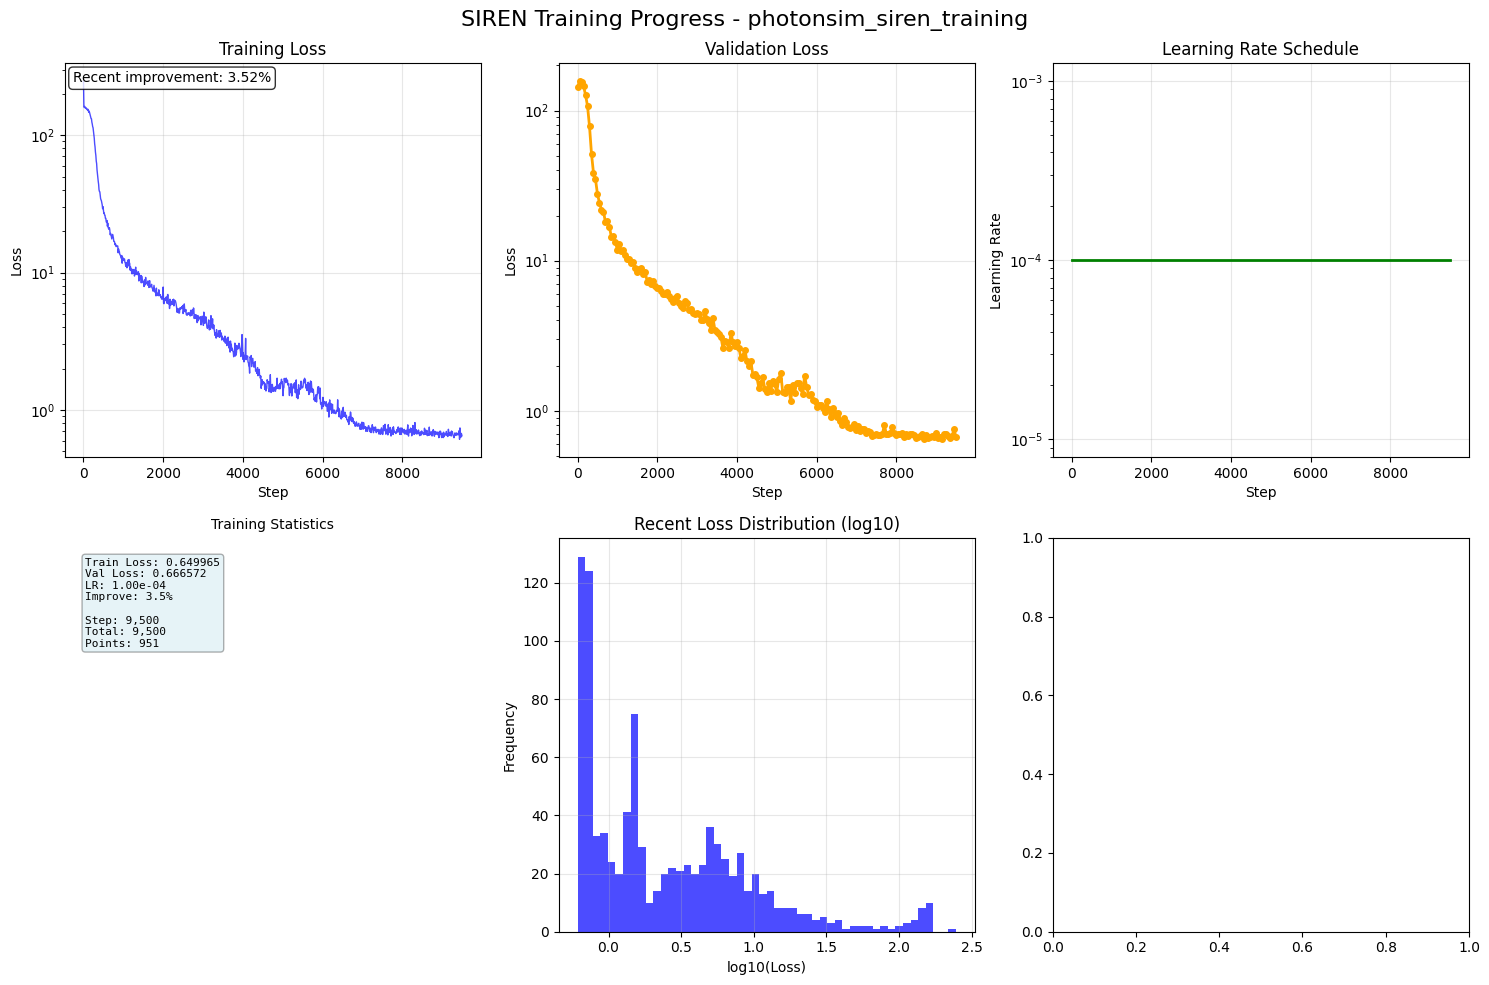

INFO:training.trainer:Step 9610/25000: Loss=0.673811, LR=1.00e-04
INFO:training.trainer:       Targets: min=0.000009, max=0.958575, mean=0.375312
INFO:training.trainer:       Predictions: min=0.000214, max=0.958746, mean=0.372833
INFO:training.trainer:Step 9620/25000: Loss=0.722386, LR=1.00e-04
INFO:training.trainer:       Targets: min=0.000031, max=0.984297, mean=0.375568
INFO:training.trainer:       Predictions: min=0.000131, max=0.954407, mean=0.379775
INFO:training.trainer:Step 9630/25000: Loss=0.674329, LR=1.00e-04
INFO:training.trainer:       Targets: min=0.000000, max=0.962438, mean=0.377020
INFO:training.trainer:       Predictions: min=0.000014, max=0.930401, mean=0.375657
INFO:training.trainer:Step 9640/25000: Loss=0.663157, LR=1.00e-04
INFO:training.trainer:       Targets: min=0.000003, max=0.964819, mean=0.377480
INFO:training.trainer:       Predictions: min=0.001090, max=0.944479, mean=0.382661
INFO:training.trainer:Step 9650/25000: Loss=0.643270, LR=1.00e-04
INFO:training.

🟢 USING CPROFSTYLE TRAINING STEP!


INFO:training.trainer:Step 9710/25000: Loss=0.640685, LR=5.00e-05
INFO:training.trainer:       Targets: min=0.000009, max=0.970437, mean=0.376292
INFO:training.trainer:       Predictions: min=0.000889, max=0.954722, mean=0.376432


KeyboardInterrupt: 

In [13]:
# Start training
print("Starting SIREN training...")
history = trainer.train()

print("\n✓ Training completed!")
print(f"Final train loss: {history['train_loss'][-1]:.6f}")
if history['val_loss']:
    print(f"Final val loss: {history['val_loss'][-1]:.6f}")

INFO:training.trainer:Saved training plot to output/photonsim_siren_training/final_training_progress.png


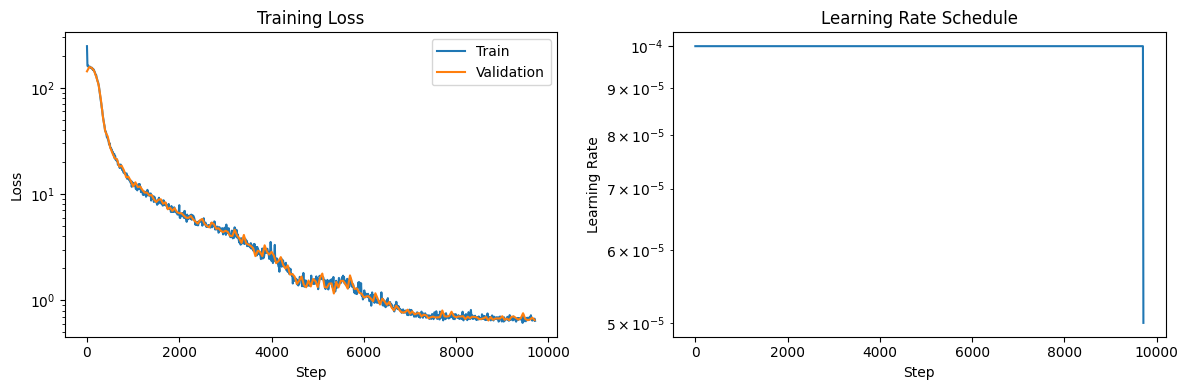

In [14]:
# Plot training history
fig = trainer.plot_training_history(save_path=output_dir / 'final_training_progress.png')
plt.show()

In [15]:
analyzer = TrainingAnalyzer(trainer, linear_dataset)

In [ ]:
# Create slice comparison plots
fig_slices = analyzer.plot_lookup_table_slices(save_path=output_dir / 'lookup_table_slices.png', figsize=(16,6))
plt.show()

INFO:training.analyzer:Analyzing error patterns on val split...


DEBUG - Energy 200 MeV angular profile:
  Table slice range: 0.00e+00 to 6.38e+02
  SIREN slice range: 2.53e-03 to 2.40e+02
  Scale ratio (SIREN/Table): 1.30e+00
  Scaling factor to match: 0.77
DEBUG - Energy 400 MeV angular profile:
  Table slice range: 0.00e+00 to 8.35e+02
  SIREN slice range: 2.53e-03 to 2.78e+02
  Scale ratio (SIREN/Table): 1.03e+00
  Scaling factor to match: 0.97
DEBUG - Energy 600 MeV angular profile:
  Table slice range: 0.00e+00 to 9.16e+02
  SIREN slice range: 2.53e-03 to 4.72e+02
  Scale ratio (SIREN/Table): 1.04e+00
  Scaling factor to match: 0.96
DEBUG - Energy 800 MeV angular profile:
  Table slice range: 0.00e+00 to 9.70e+02
  SIREN slice range: 2.53e-03 to 6.35e+02
  Scale ratio (SIREN/Table): 1.01e+00
  Scaling factor to match: 0.99
DEBUG - Energy 1000 MeV angular profile:
  Table slice range: 0.00e+00 to 9.43e+02
  SIREN slice range: 2.53e-03 to 4.63e+02
  Scale ratio (SIREN/Table): 9.47e-01
  Scaling factor to match: 1.06
DEBUG - Distance profile coor

INFO:training.analyzer:Saved slice comparison plot to output/photonsim_siren_training/lookup_table_slices.png


🔍 Quick normalization check...
Base dataset targets: 0.014582 to 0.879069
Consistent dataset targets: 0.014582 to 0.879069
✅ SUCCESS! Normalization is now consistent
   → SIREN training and evaluation use identical [0,1] scales
   → Plots should now match visually!

🚀 Ready to proceed with training and analysis!
